<a href="https://colab.research.google.com/github/mfvc-campinho/M.EGI026-Computer-Vision-Assignment-2/blob/main/C%C3%B3pia_de_%5BVersion_1%5D_%5BM_EGI026%5D_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

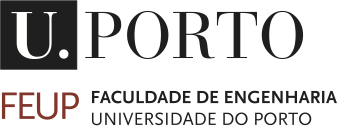   

**<h1>[M.EGI026] Computer Vision</h1>**

**<h2>Assignment #2 - XXX</h2>**

* **Filipa Mota** (up202402072@fe.up.pt)
* **Matheus Campinho** (up202402072@fe.up.pt)
<p> Department of Industrial Engineering and Management </p>  
FEUP  

----

**<h1>Content</h1>**
<ol>
    <li><a href="#ref1">Task 1: XXX</a></li>
    <li><a href="#ref2">Task 2: XXX</a></li>
    <li><a href="#ref3">Task 3: XXX</a></li>
    <li><a href="#ref4">Task 4: XXX</a></li>
    <li><a href="#ref5">Task 5: XXX</a></li>
    <li><a href="#ref6"> References </a></li>
</ol>
<hr>

# **Problem Description**

The goal of this assignment is to xxx.


---
The below code cell first removes any existing content in the /content/ directory to ensure a clean slate. Then, it downloads a zip file containing the assignment data from a GitHub repository created for this purpose and extracts its contents into the /content/ directory. Finally, it prints the current directory path and lists the contents of the extracted folder.

**💾 CPU VS GPU**

Falta Descrição:
IMP: O GPU tem tempo máximo diário.

Para ativar:
* Vai à seccção Tempo de execução
* Clica em alterat tipo de tempo de execução
* Define Hardware Accelerator = GPU
* Reinicia o ambiente




**🛠️ Setup and Imports**

This cell imports the necessary libraries for the Computer Vision assignment:

* **`numpy` (np):** Essential for numerical operations, especially handling array-based image data.
* **`matplotlib.pyplot` (plt):** Used for plotting images and visualizing results.
* **`cv2` (cv):** The OpenCV library, which is the core tool for image processing and computer vision tasks.
* **`glob`:** Used to efficiently retrieve lists of files matching a specified pattern (e.g., all image files in a directory).
* **`os`:** Provides a way of interacting with the operating system, useful for path manipulation.
* **`pandas` (pd):** Used for data manipulation and analysis, particularly for creating and displaying the required result tables.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from pathlib import Path
import json
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [ ]:
# Define Execution Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi
torch.cuda.is_available()

Tue Dec  2 20:22:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             13W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

# --- 0. Prepare the Basis

## Network CNN Module -> Simpler just to explore this models.

In [ ]:
# --- NetworkCNN Model (adapted from Collab class 10) ---
class NetworkCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        dummy_input = torch.randn(1, 1, 64, 64) # Batch size 1, 1 channel, 64x64
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            flattened_size = torch.flatten(x, 1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
print("✔️ NetworkCNN model defined.")

✔️ NetworkCNN model defined.


## Helper Functions Train/Validation/Test

In [ ]:
# --- Helper Functions ---
def saveModel(model: nn.Module, path: str):
    torch.save(model.state_dict(), path)
    print(f"Modelo guardado em: {path}")

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device,
          num_epochs, path_model, problem_type="multiclass", verbatim=True):
    model.to(device)
    best_val_acc = -1 # Keep track of best validation accuracy
    best_epoch = -1

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc  = 0.0

        for images, labels in train_dataloader:
            images = images.to(device)
            if problem_type == "binary":
                labels = labels.float().unsqueeze(1).to(device)
            else:
                labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if problem_type == "binary":
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                acc = (preds == labels).float().mean().item()
            else:
                preds = outputs.argmax(1)
                acc = (preds == labels).float().mean().item()

            running_acc += acc

        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_acc  = running_acc  / len(train_dataloader)

        # --- Validation after each epoch ---
        epoch_val_loss, epoch_val_acc = validate(model, val_dataloader, loss_fn, device, problem_type=problem_type)

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            saveModel(model, path_model)
            best_val_acc = epoch_val_acc
            best_epoch = epoch

            if verbatim:
                print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={epoch_train_loss:.4f} | Train Acc={epoch_train_acc:.4f} | Val Loss={epoch_val_loss:.4f} | Val Acc={epoch_val_acc:.4f} (Best)")
        elif verbatim:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={epoch_train_loss:.4f} | Train Acc={epoch_train_acc:.4f} | Val Loss={epoch_val_loss:.4f} | Val Acc={epoch_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val_acc, best_epoch

def validate(model, dataloader, loss_fn, device, problem_type="multiclass"):
    model.eval()
    model.to(device)
    running_loss = 0.0
    running_acc  = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            if problem_type == "binary":
                labels = labels.float().unsqueeze(1).to(device)
            else:
                labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            if problem_type == "binary":
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                acc = (preds == labels).float().mean().item()
            else:
                preds = outputs.argmax(1)
                acc = (preds == labels).float().mean().item()

            running_acc += acc

    val_loss = running_loss / len(dataloader)
    val_acc  = running_acc  / len(dataloader)
    return val_loss, val_acc

def test(model, dataloader, loss_fn, device, problem_type="multiclass"):
    model.eval()
    model.to(device)
    all_preds  = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            if problem_type == "binary":
                labels_in = labels.float().unsqueeze(1).to(device)
            else:
                labels_in = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels_in)
            running_loss += loss.item()

            if problem_type == "binary":
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float().cpu().numpy().flatten()
            else:
                preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader)
    return test_loss, all_preds, all_labels

## Evaluate

In [ ]:
def get_predictions(model, dataloader, device, problem_type="multiclass"):
    model.eval()
    model.to(device)
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)

            if problem_type == "multiclass":
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_probs.append(probs.cpu())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
            else:
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).long().squeeze(1)
                all_probs.append(probs.cpu())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

    all_probs = torch.cat(all_probs, dim=0)
    return all_labels, all_preds, all_probs

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

def model_complexity(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Complexity: {total_params:,} trainable parameters")

def evaluate_model(model, dataloader, class_names, device, problem_type="multiclass"):
    '''
    Prints all the metrics
    '''
    true_labels, pred_labels, probs = get_predictions(
        model, dataloader, device, problem_type=problem_type
    )

    true_labels = torch.tensor(true_labels)
    pred_labels = torch.tensor(pred_labels)

    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\nAccuracy: {accuracy:.4f}")

    f1_macro = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1_micro = f1_score(true_labels, pred_labels, average='micro', zero_division=0)
    f1_weighted = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    print(f"F1-score (macro):    {f1_macro:.4f}")
    print(f"F1-score (micro):    {f1_micro:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))

    plot_confusion_matrix(true_labels, pred_labels, class_names)
    model_complexity(model)

    return true_labels, pred_labels, probs

def get_metrics_for_table(model, dataloader, device, problem_type="multiclass"):
    """
    Returns only the numeric metrics needed for comparison tables.
    No prints, no plots — clean output.
    """
    true_labels, pred_labels, probs = get_predictions(
        model, dataloader, device, problem_type=problem_type
    )

    # Convert to tensors
    y_true = torch.tensor(true_labels)
    y_pred = torch.tensor(pred_labels)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted
    }

print("✔️ All helper functions defined.")

✔️ All helper functions defined.


# --- 1. Data Setup (re-run necessary parts for context) ---


In [ ]:
# --- 1. Data Setup (re-run necessary parts for context) ---
# Define Execution Device (if not already defined globally in a persistent cell)
# DEVICE is already defined!

# Ensure dataset is present
data_root_dir = Path("/content/InfraredSolarModules")
if not data_root_dir.exists() or not any(data_root_dir.iterdir()):
    print("Downloading and extracting dataset...")
    !rm -rf /content/*
    !wget -q -O /content/infrared.zip \
      "https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip"
    !unzip -q /content/infrared.zip -d /content/
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already present, skipping download and extraction.")

data_dir = Path("/content/InfraredSolarModules")
meta_path = data_dir / "module_metadata.json"
with open(meta_path, "r") as f:
    metadata = json.load(f)
print("✔️ Metadata loaded:", len(metadata), "imagens")

Dataset downloaded and extracted.
✔️ Metadata loaded: 20000 imagens


# --- 2. Create DataFrame with 'path' and class mappings ---

In [ ]:
# --- 2. Create DataFrame with 'path' and class mappings ---
all_classes = sorted({info["anomaly_class"] for info in metadata.values()})
classes_map = {cls: idx for idx, cls in enumerate(all_classes)}
idx_to_classes = {v: k for k, v in classes_map.items()}

rows = []
for img_id, info in metadata.items():
    full_image_path = data_dir / info["image_filepath"]
    rows.append({"img_id": img_id, "label": info["anomaly_class"], "path": str(full_image_path)})
df = pd.DataFrame(rows)
print("✔️ DataFrame created with 'path' column.")

✔️ DataFrame created with 'path' column.


# --- Extra: Análise do Balanceamento do Dataset Original

É fundamental verificar a distribuição das classes no dataset para identificar se existe um desbalanceamento. Um dataset desbalanceado pode levar a modelos que performam bem em classes majoritárias, mas mal em classes minoritárias.

/tmp/ipython-input-831758874.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


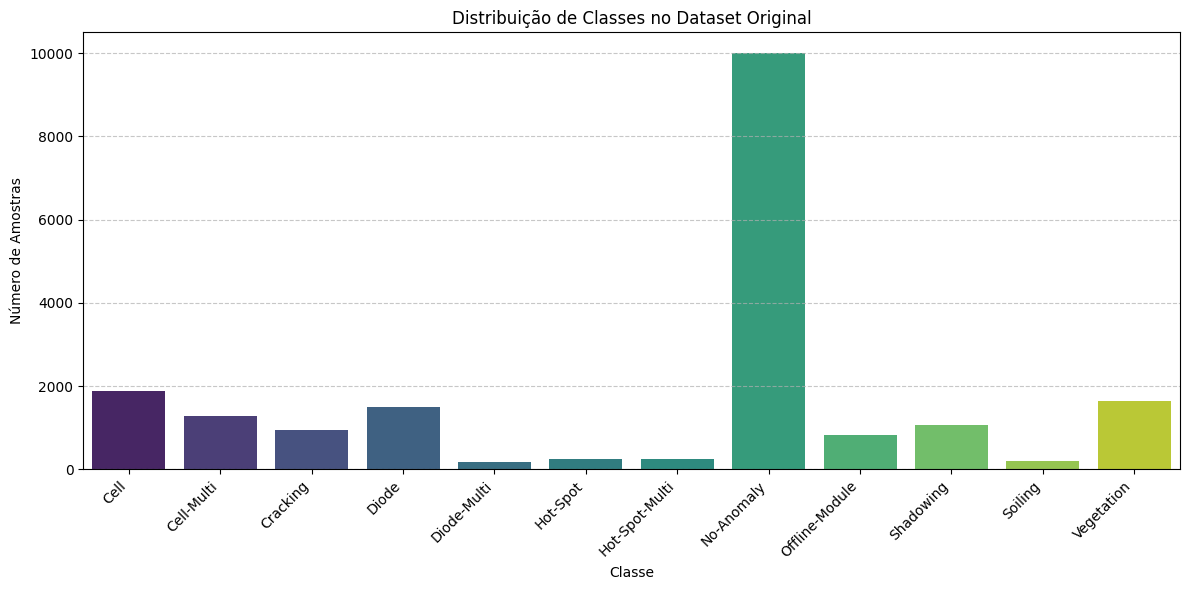

Distribuição de Classes:
 label
Cell               1877
Cell-Multi         1288
Cracking            940
Diode              1499
Diode-Multi         175
Hot-Spot            249
Hot-Spot-Multi      246
No-Anomaly        10000
Offline-Module      827
Shadowing          1056
Soiling             204
Vegetation         1639
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate class distribution
class_counts = df['label'].value_counts().sort_index()

# Plotting the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribuição de Classes no Dataset Original')
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Distribuição de Classes:\n", class_counts)

Visualizing 5 random sample images...


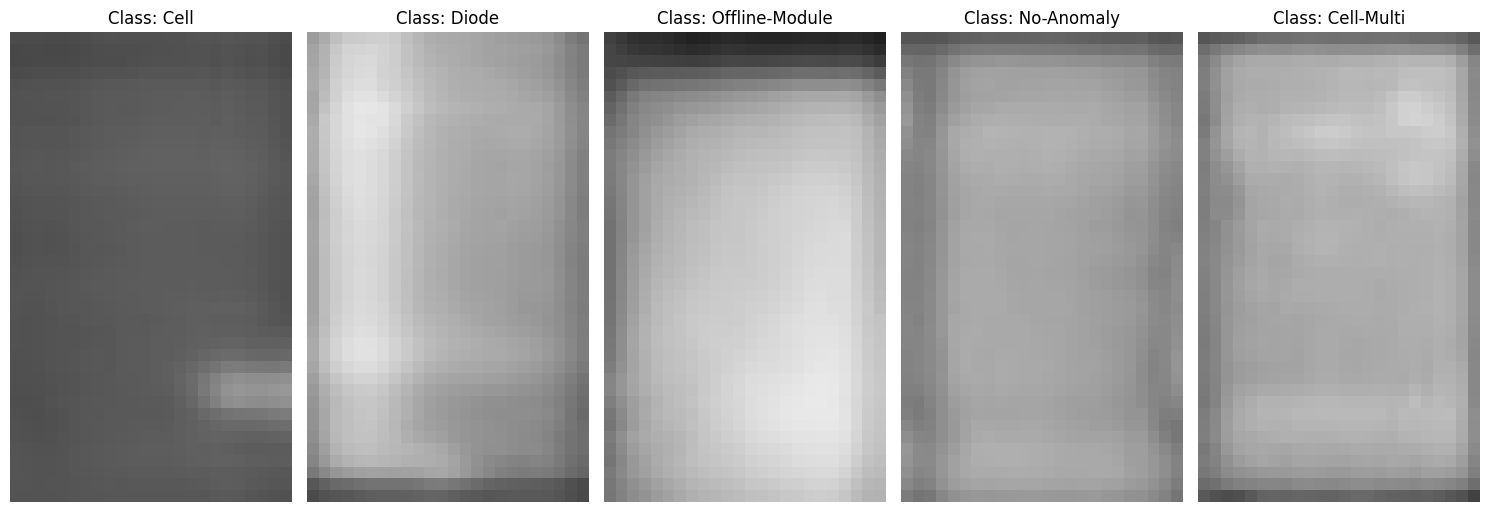

In [ ]:
print("Visualizing 5 random sample images...")

# Get unique image filenames to avoid duplicates if any
# The 'image_filepath' is stored in the 'path' column of the DataFrame
unique_images = df['path'].unique()

# Randomly select 5 image file paths
sample_image_paths = np.random.choice(unique_images, size=5, replace=False)

plt.figure(figsize=(15, 10))
for i, img_filepath_relative in enumerate(sample_image_paths):
    # Construct full image path
    # The full path is already in the 'path' column
    full_img_path = Path(img_filepath_relative)

    # Load image using OpenCV
    img = cv.imread(str(full_img_path))

    if img is not None:
        # Convert BGR to RGB for matplotlib display
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Get the anomaly class for this image
        anomaly_class = df[df['path'] == img_filepath_relative]['label'].iloc[0]

        plt.subplot(1, 5, i + 1) # 1 row, 5 columns
        plt.imshow(img_rgb)
        plt.title(f"Class: {anomaly_class}")
        plt.axis('off')
    else:
        print(f"Warning: Could not load image {full_img_path}")

plt.tight_layout()
plt.show()

# --- 3. Data Split (Train/Val/Test) (from U4pfjvYnpOFW) ---

In [ ]:
# --- 3. Data Split (Train/Val/Test) (from U4pfjvYnpOFW) ---
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)
print("✔️ Data split into train, validation, and test sets.")

# --- 4. Create Model A, B, C specific dataframes with label conversion ---

In [ ]:
# --- 4. Create Model A, B, C specific dataframes with label conversion ---
# Model A (Binary Classification: No-Anomaly vs Anomaly)
train_df_A = train_df.copy()
train_df_A["label"] = train_df_A["label"].apply(lambda x: 0 if x=="No-Anomaly" else 1)

val_df_A = val_df.copy()
val_df_A["label"] = val_df_A["label"].apply(lambda x: 0 if x=="No-Anomaly" else 1)

test_df_A = test_df.copy()
test_df_A["label"] = test_df_A["label"].apply(lambda x: 0 if x=="No-Anomaly" else 1)
print("✔️ Model A dataframes created.")

# Model B (Multiclass Classification: 11 Anomaly Classes, 'No-Anomaly' removed)
train_df_B = train_df[train_df["label"]!="No-Anomaly"].copy()
val_df_B   = val_df[val_df["label"]!="No-Anomaly"].copy()
test_df_B  = test_df[test_df["label"]!="No-Anomaly"].copy()

# Create a new classes_map for Model B (11 classes) and convert labels to integers
class_names_B = sorted([cls for cls in all_classes if cls != 'No-Anomaly'])
classes_map_B = {cls: idx for idx, cls in enumerate(class_names_B)}

train_df_B["label"] = train_df_B["label"].map(classes_map_B)
val_df_B["label"] = val_df_B["label"].map(classes_map_B)
test_df_B["label"] = test_df_B["label"].map(classes_map_B)
print("✔️ Model B dataframes created.")

# Model C (Multiclass Classification: All 12 Original Classes)
train_df_C = train_df.copy()
val_df_C   = val_df.copy()
test_df_C  = test_df.copy()

# Convert string labels to integer indices for Model C dataframes using the original classes_map
train_df_C["label"] = train_df_C["label"].map(classes_map)
val_df_C["label"] = val_df_C["label"].map(classes_map)
test_df_C["label"] = test_df_C["label"].map(classes_map)
print("✔️ Model C dataframes created.")

# --- 5. Define Transforms  ---

In [ ]:
# --- 5. Define Transforms  ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(
        mean=(0.5,),
        std=(0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(
        mean=(0.5,),
        std=(0.5,))
])
print("✔️ `train_transform` and `val_test_transform` defined.")

✔️ `train_transform` and `val_test_transform` defined.


# --- 6.&7. Re-define SolarDataset class & Create SolarDataset instances with new transforms ---



In [ ]:
# --- 6. Re-define SolarDataset class ---
class SolarDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("L")
        label = row["label"]

        if self.transform:
            image = self.transform(image)

        return image, label
print("✔️ SolarDataset class re-defined.")

# --- 7. Create SolarDataset instances with new transforms ---
train_A = SolarDataset(train_df_A, transform=train_transform)
val_A   = SolarDataset(val_df_A, transform=val_test_transform)
test_A  = SolarDataset(test_df_A, transform=val_test_transform)

train_B = SolarDataset(train_df_B, transform=train_transform)
val_B   = SolarDataset(val_df_B, transform=val_test_transform)
test_B  = SolarDataset(test_df_B, transform=val_test_transform)

train_C = SolarDataset(train_df_C, transform=train_transform)
val_C   = SolarDataset(val_df_C, transform=val_test_transform)
test_C  = SolarDataset(test_df_C, transform=val_test_transform)

print("✔️ SolarDataset instances updated with `train_transform` and `val_test_transform`.")

# --- 8. DataLoaders with WeightedRandomSampler ---


In [ ]:
# --- 8. DataLoaders with WeightedRandomSampler ---


# --- Calculate class weights for WeightedRandomSampler for each training set ---
def calculate_class_weights(dataset):
    labels = [label for _, label in dataset] # Extract all labels
    class_counts = np.bincount(labels)
    # Ensure class_counts has at least 1 entry for all potential classes if some are missing
    # For Model A, this will be [count_0, count_1]
    # For Model B, this will be [count_0, ..., count_10]
    # For Model C, this will be [count_0, ..., count_11]

    # Get the max number of classes expected based on the dataset
    if hasattr(dataset, 'df') and 'label' in dataset.df.columns:
        num_classes = len(dataset.df['label'].unique())
    else:
        num_classes = max(labels) + 1 if labels else 0 # Fallback

    # Pad class_counts with zeros if some classes are missing
    padded_class_counts = np.zeros(num_classes, dtype=int)
    padded_class_counts[:len(class_counts)] = class_counts

    # Handle case where class_counts might be empty or all zeros to avoid division by zero
    if np.sum(padded_class_counts) == 0: # If dataset is empty or has no labels
        return torch.tensor([1.0] * num_classes, dtype=torch.float)

    class_weights = 1. / padded_class_counts
    # Replace inf with 0 for classes that might not appear in the training set
    class_weights[np.isinf(class_weights)] = 0
    # Normalize weights so they sum to 1 (optional, but good practice)
    class_weights = class_weights / np.sum(class_weights)
    return torch.tensor(class_weights, dtype=torch.float)

# Calculate weights for Model A training set
weights_A = calculate_class_weights(train_A)
# Assign a weight for each sample based on its class weight
samples_weight_A = [weights_A[label] for _, label in train_A]
sampler_A = torch.utils.data.WeightedRandomSampler(samples_weight_A, len(samples_weight_A), replacement=True)

# Calculate weights for Model B training set
weights_B = calculate_class_weights(train_B)
samples_weight_B = [weights_B[label] for _, label in train_B]
sampler_B = torch.utils.data.WeightedRandomSampler(samples_weight_B, len(samples_weight_B), replacement=True)

# Calculate weights for Model C training set
weights_C = calculate_class_weights(train_C)
samples_weight_C = [weights_C[label] for _, label in train_C]
sampler_C = torch.utils.data.WeightedRandomSampler(samples_weight_C, len(samples_weight_C), replacement=True)

print("✔️ Class weights calculated and `WeightedRandomSampler` instances created for training sets A, B, and C.")

# --- Update DataLoaders with WeightedRandomSampler ---
# Training DataLoaders will use the sampler; shuffle must be False when using a sampler.
loader_train_A = torch.utils.data.DataLoader(train_A, batch_size=32, sampler=sampler_A)
loader_val_A   = torch.utils.data.DataLoader(val_A, batch_size=32, shuffle=False)
loader_test_A  = torch.utils.data.DataLoader(test_A, batch_size=32, shuffle=False)

loader_train_B = torch.utils.data.DataLoader(train_B, batch_size=32, sampler=sampler_B)
loader_val_B   = torch.utils.data.DataLoader(val_B, batch_size=32, shuffle=False)
loader_test_B  = torch.utils.data.DataLoader(test_B, batch_size=32, shuffle=False)

loader_train_C = torch.utils.data.DataLoader(train_C, batch_size=32, sampler=sampler_C)
loader_val_C   = torch.utils.data.DataLoader(val_C, batch_size=32, shuffle=False)
loader_test_C  = torch.utils.data.DataLoader(test_C, batch_size=32, shuffle=False)

print("✔️ DataLoaders updated with `WeightedRandomSampler` for training sets.")

# --- 9. Run the Models

In [ ]:
# --- 9. Model A Training and Evaluation ---
print("\n=== Training Model A ===")
model_A = NetworkCNN(num_classes=1).to(DEVICE)
loss_A = nn.BCEWithLogitsLoss()
optimizer_A = torch.optim.SGD(
    model_A.parameters(),
    lr=0.005,
    momentum=0.9
)

train_losses_A, train_accs_A, val_losses_A, val_accs_A, best_val_acc_A, best_epoch_A = train(
    model=model_A,
    train_dataloader=loader_train_A,
    val_dataloader=loader_val_A,
    loss_fn=loss_A,
    optimizer=optimizer_A,
    device=DEVICE,
    num_epochs=20,
    path_model="model_A_balanced.pth",
    problem_type="binary"
)

print(f"\nModel A - Best Validation Accuracy: {best_val_acc_A:.4f} at Epoch {best_epoch_A+1}")

print("\n=== Evaluating Model A ===")

# For Model A, `class_names` should reflect the binary classification
class_names_A = ['No-Anomaly', 'Anomaly']
metrics_A = evaluate_model(model_A, loader_test_A, ["No-Anomaly", "Anomaly"], DEVICE, problem_type="binary")

In [ ]:

# --- 10. Model B Training and Evaluation ---
print("\n=== Training Model B ===")
model_B = NetworkCNN(num_classes=len(class_names_B)).to(DEVICE)
loss_B = nn.CrossEntropyLoss()
optimizer_B = torch.optim.SGD(
    model_B.parameters(),
    lr=0.005,
    momentum=0.9
)

train_losses_B, train_accs_B, val_losses_B, val_accs_B, best_val_acc_B, best_epoch_B = train(
    model=model_B,
    train_dataloader=loader_train_B,
    val_dataloader=loader_val_B,
    loss_fn=loss_B,
    optimizer=optimizer_B,
    device=DEVICE,
    num_epochs=20,
    path_model="model_B_balanced.pth",
    problem_type="multiclass"
)

print(f"\nModel B - Best Validation Accuracy: {best_val_acc_B:.4f} at Epoch {best_epoch_B+1}")

print("\n=== Evaluating Model B ===")
metrics_B = evaluate_model(model_B, loader_test_B, class_names_B, DEVICE, problem_type="multiclass")

In [ ]:
# --- 11. Model C Training and Evaluation ---
print("\n=== Training Model C ===")
model_C = NetworkCNN(num_classes=len(all_classes)).to(DEVICE)
loss_C = nn.CrossEntropyLoss()
optimizer_C = torch.optim.SGD(
    model_C.parameters(),
    lr=0.005,
    momentum=0.9
)

train_losses_C, train_accs_C, val_losses_C, val_accs_C, best_val_acc_C, best_epoch_C = train(
    model=model_C,
    train_dataloader=loader_train_C,
    val_dataloader=loader_val_C,
    loss_fn=loss_C,
    optimizer=optimizer_C,
    device=DEVICE,
    num_epochs=20,
    path_model="model_C_balanced.pth",
    problem_type="multiclass"
)

print(f"\nModel C - Best Validation Accuracy: {best_val_acc_C:.4f} at Epoch {best_epoch_C+1}")

print("\n=== Evaluating Model C ===")
metrics_C = evaluate_model(model_C, loader_test_C, classes_map, DEVICE, problem_type="multiclass")


Accuracy: 0.8700
F1-score (macro):    0.8698
F1-score (micro):    0.8700
F1-score (weighted): 0.8698

=== Classification Report ===
              precision    recall  f1-score   support

  No-Anomaly       0.84      0.91      0.88      1000
     Anomaly       0.90      0.83      0.86      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



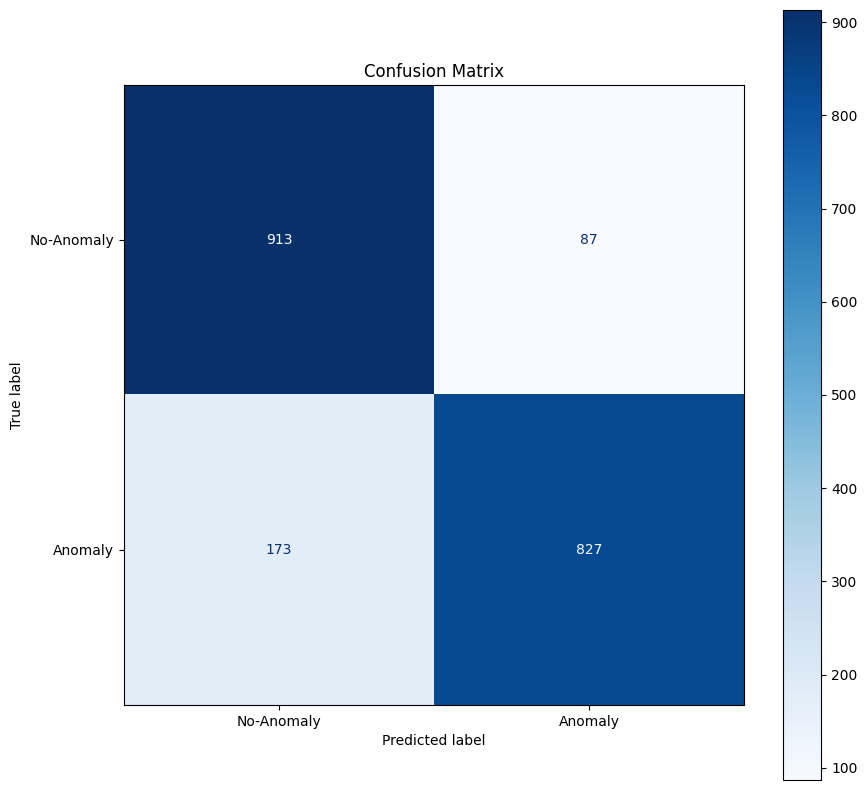


Model Complexity: 337,421 trainable parameters

Accuracy: 0.5490
F1-score (macro):    0.5064
F1-score (micro):    0.5490
F1-score (weighted): 0.5527

=== Classification Report ===
                precision    recall  f1-score   support

          Cell       0.53      0.49      0.51       187
    Cell-Multi       0.35      0.26      0.30       129
      Cracking       0.61      0.61      0.61        94
         Diode       0.93      0.75      0.83       150
   Diode-Multi       0.54      0.76      0.63        17
      Hot-Spot       0.36      0.64      0.46        25
Hot-Spot-Multi       0.24      0.32      0.28        25
Offline-Module       0.45      0.80      0.58        83
     Shadowing       0.65      0.64      0.65       106
       Soiling       0.14      0.30      0.19        20
    Vegetation       0.62      0.47      0.53       164

      accuracy                           0.55      1000
     macro avg       0.49      0.55      0.51      1000
  weighted avg       0.58      0.

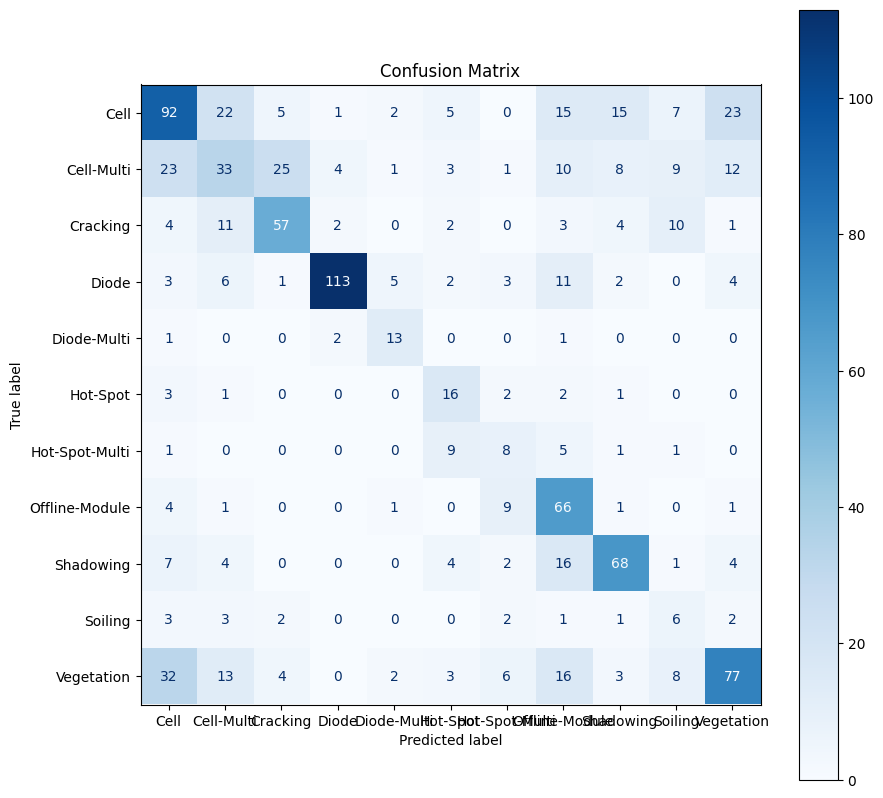


Model Complexity: 338,271 trainable parameters

Accuracy: 0.6370
F1-score (macro):    0.4866
F1-score (micro):    0.6370
F1-score (weighted): 0.6506

=== Classification Report ===
                precision    recall  f1-score   support

          Cell       0.56      0.48      0.51       187
    Cell-Multi       0.42      0.18      0.25       129
      Cracking       0.56      0.62      0.59        94
         Diode       0.74      0.91      0.81       150
   Diode-Multi       0.58      0.65      0.61        17
      Hot-Spot       0.16      0.52      0.24        25
Hot-Spot-Multi       0.20      0.48      0.28        25
    No-Anomaly       0.89      0.71      0.79      1000
Offline-Module       0.35      0.67      0.46        83
     Shadowing       0.44      0.66      0.53       106
       Soiling       0.20      0.30      0.24        20
    Vegetation       0.49      0.57      0.52       164

      accuracy                           0.64      2000
     macro avg       0.46      0.

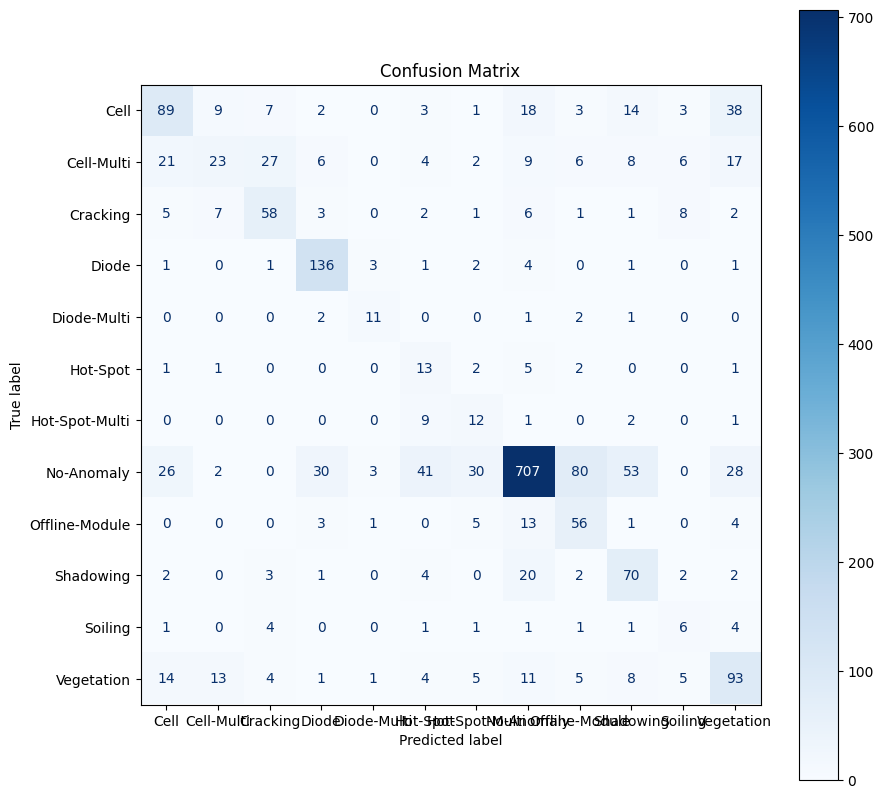


Model Complexity: 338,356 trainable parameters


In [ ]:
# === Printar


# Loss Curves

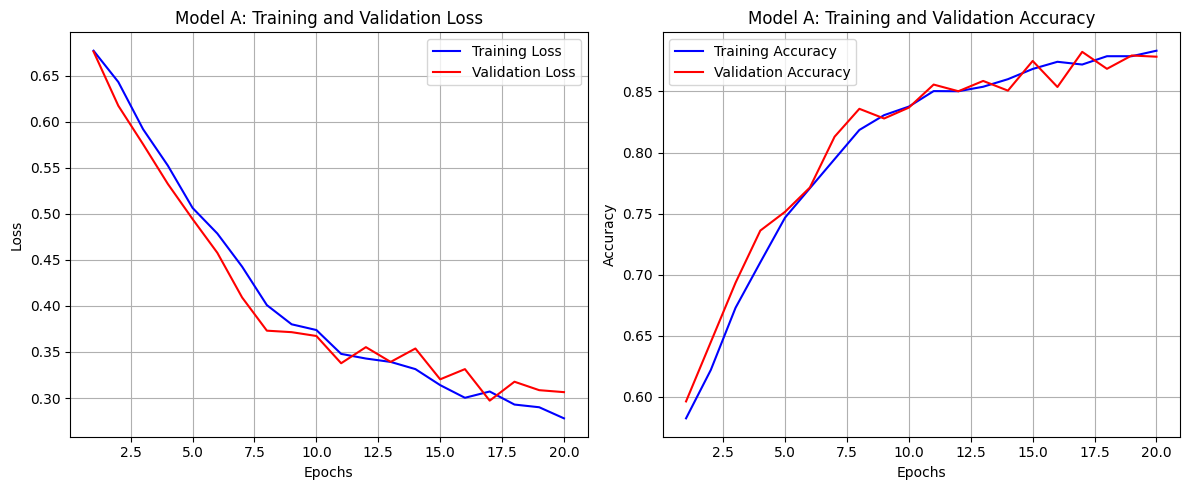

In [ ]:
epochs = range(1, len(train_losses_A) + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_A, 'b', label='Training Loss')
plt.plot(epochs, val_losses_A, 'r', label='Validation Loss')
plt.title('Model A: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_A, 'b', label='Training Accuracy')
plt.plot(epochs, val_accs_A, 'r', label='Validation Accuracy')
plt.title('Model A: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

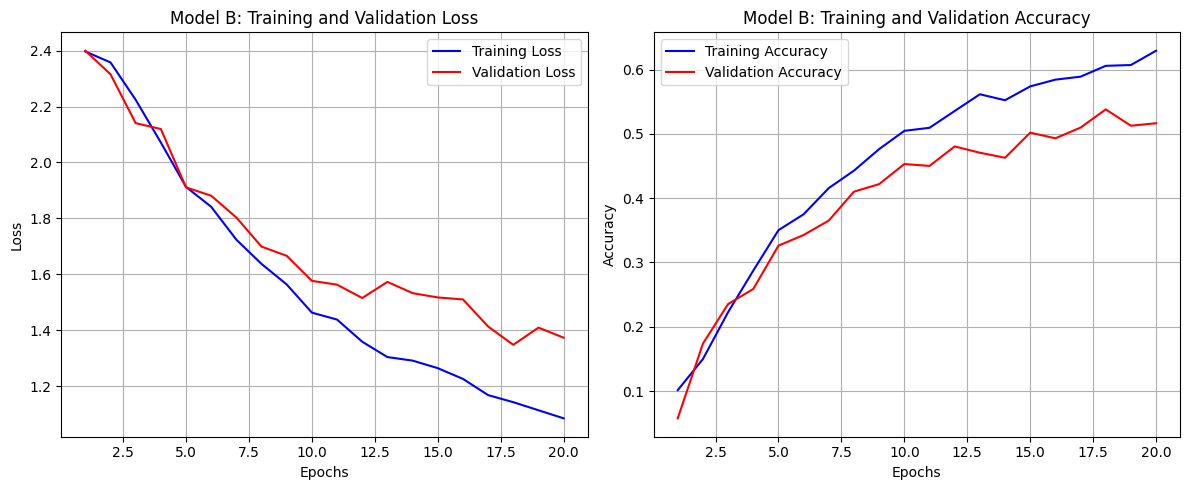

In [ ]:
epochs = range(1, len(train_losses_B) + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_B, 'b', label='Training Loss')
plt.plot(epochs, val_losses_B, 'r', label='Validation Loss')
plt.title('Model B: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_B, 'b', label='Training Accuracy')
plt.plot(epochs, val_accs_B, 'r', label='Validation Accuracy')
plt.title('Model B: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

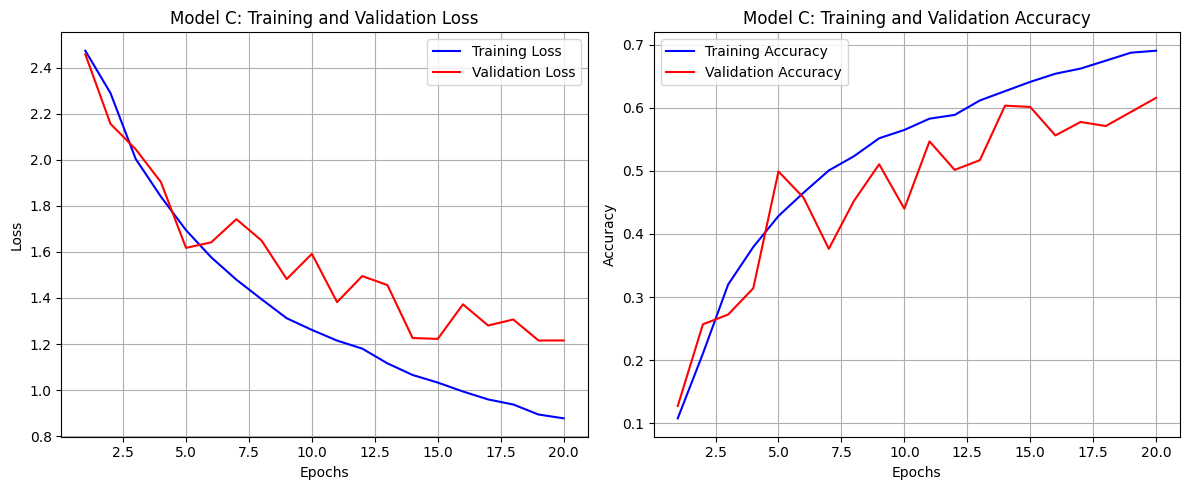

In [ ]:
epochs = range(1, len(train_losses_C) + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_C, 'b', label='Training Loss')
plt.plot(epochs, val_losses_C, 'r', label='Validation Loss')
plt.title('Model C: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_C, 'b', label='Training Accuracy')
plt.plot(epochs, val_accs_C, 'r', label='Validation Accuracy')
plt.title('Model C: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Metrics table to compare

In [ ]:
metrics_A_val_table = get_metrics_for_table(model_A, loader_val_A, DEVICE, problem_type="binary")
print("Model A Validation Metrics:", metrics_A_val_table)
metrics_A_test_table = get_metrics_for_table(model_A, loader_test_A, DEVICE, problem_type="binary")
print("Model A Test Metrics:", metrics_A_test_table)

Model A Test Metrics: {'accuracy': 0.87, 'f1_macro': 0.8697591847325705, 'f1_micro': 0.87, 'f1_weighted': 0.8697591847325705}


In [ ]:
metrics_B_val_table = get_metrics_for_table(model_B, loader_val_B, DEVICE, problem_type="multiclass")
print("Model B Validation Metrics:", metrics_B_val_table)
metrics_B_test_table = get_metrics_for_table(model_B, loader_test_B, DEVICE, problem_type="binary")
print("Model A Test Metrics:", metrics_B_test_table)

Model B Validation Metrics: {'accuracy': 0.517, 'f1_macro': 0.49468217735330866, 'f1_micro': 0.517, 'f1_weighted': 0.5241385705986399}


In [ ]:
metrics_C_val_table = get_metrics_for_table(model_C, loader_val_C, DEVICE, problem_type="multiclass")
print("Model C Validation Metrics:", metrics_C_val_table)
metrics_C_test_table = get_metrics_for_table(model_C, loader_test_C, DEVICE, problem_type="multiclass")
print("Model C Validation Metrics:", metrics_C_test_table)

Model C Validation Metrics: {'accuracy': 0.6145, 'f1_macro': 0.4685571213866863, 'f1_micro': 0.6145, 'f1_weighted': 0.6304528243965539}
Model C Validation Metrics: {'accuracy': 0.637, 'f1_macro': 0.4865553783508658, 'f1_micro': 0.637, 'f1_weighted': 0.6506179190097766}


In [ ]:
comparison_df_extended = pd.DataFrame({
    "Model": [
        "A (Binary) - Test", "A (Binary) - Validation",
        "B (11-Class) - Test", "B (11-Class) - Validation",
        "C (12-Class) - Test", "C (12-Class) - Validation"
    ],
    "Accuracy": [
        metrics_A_test_table["accuracy"],
        metrics_A_val_table["accuracy"],
        metrics_B_table["accuracy"], # metrics_B_table is already for test set
        metrics_B_val_table["accuracy"],
        metrics_C_table["accuracy"], # metrics_C_table is already for test set
        metrics_C_val_table["accuracy"]
    ],
    "F1 Macro": [
        metrics_A_test_table["f1_macro"],
        metrics_A_val_table["f1_macro"],
        metrics_B_table["f1_macro"],
        metrics_B_val_table["f1_macro"],
        metrics_C_table["f1_macro"],
        metrics_C_val_table["f1_macro"]
    ],
    "F1 Weighted": [
        metrics_A_test_table["f1_weighted"],
        metrics_A_val_table["f1_weighted"],
        metrics_B_table["f1_weighted"],
        metrics_B_val_table["f1_weighted"],
        metrics_C_table["f1_weighted"],
        metrics_C_val_table["f1_weighted"]
    ],
    "Trainable Parameters": [
        sum(p.numel() for p in model_A.parameters() if p.requires_grad),
        sum(p.numel() for p in model_A.parameters() if p.requires_grad),
        sum(p.numel() for p in model_B.parameters() if p.requires_grad),
        sum(p.numel() for p in model_B.parameters() if p.requires_grad),
        sum(p.numel() for p in model_C.parameters() if p.requires_grad),
        sum(p.numel() for p in model_C.parameters() if p.requires_grad)
    ]
})

comparison_df_extended = comparison_df_extended.set_index("Model")
display(comparison_df_extended.round(4))

comparison_df_extended.to_csv("model_comparison_extended.csv")
print("Saved as model_comparison_extended.csv")

,Accuracy,F1 Macro,F1 Weighted,Trainable Parameters
Model,,,,
A (Binary) - Test,0.8700,0.8698,0.8698,337421
A (Binary) - Validation,0.8785,0.8784,0.8784,337421
B (11-Class) - Test,0.5490,0.5064,0.5527,338271
B (11-Class) - Validation,0.5170,0.4947,0.5241,338271
C (12-Class) - Test,0.6370,0.4866,0.6506,338356
C (12-Class) - Validation,0.6145,0.4686,0.6305,338356


Saved as model_comparison_extended.csv


# Reference

:# Documento muito interessante sobre data augmentation, se calhar deviamos tentar os 4 e escolher o melhor: https://rcs.cic.ipn.mx/2024_153_12/Assessing%20the%20Impact%20of%20Data%20Augmentation%20on%20Photovoltaic%20Module.pdf#:~:text=Deep%20Neural%20Networks%20%28DNNs%29%20have%20emerged%20as%20a,a%20substantial%20amount%20of%20high-quality%20and%20annotated%20data.